# Data Exploration

## Setting up 

### Installing Dependencies

In [3]:
#!python -m pip install numpy
#!python -m pip install pandas
#!python -m pip install torch
#!python -m pip install matplotlib
#!python -m pip install sklearn
#!python -m pip install torchvision
#!python -m pip install tqdm
!python -m pip install cv2

import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import tqdm.auto as tqdm

import os
from PIL import Image
from sklearn.metrics import accuracy_score
import torchvision
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

plt.style.use('seaborn')

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


### Checking Data

Let's make sure that we have the data that we need. If it's not there, then you have to upload it (download it from the mail and drag it to the `data` folder in JupyterLab.

In [10]:
files = ['diseases_characteristics.csv', 'dermx_labels.csv']

for file in files:
    assert file in os.listdir('./data/'), f'{file} should be in the ./data/ folder'

# Investigating Labels

In [11]:
dermx_labels = pd.read_csv('./data/dermx_labels.csv')
dermx_labels.groupby('diagnosis').size()

#Transform the labels.
le = LabelEncoder().fit(dermx_labels['diagnosis'].tolist())
dermx_labels['target'] = le.transform(dermx_labels['diagnosis'])

#Write up the image path.
dermx_labels['path'] = dermx_labels['image_id'].apply(lambda x : os.path.join('data', 'images', f'{x}.jpeg'))

#Drop images that could not be found.
n_before = len(dermx_labels)

dermx_labels = dermx_labels.loc[dermx_labels['path'].apply(lambda x : os.path.exists(x))]

n_after  = len(dermx_labels)

print(f'Observations before: {n_before}')
print(f'Observations after: {n_after}')

assert n_after > 0, 'Images could not be found. Make sure you have unpacked images into ./data/images/'

Observations before: 492
Observations after: 453


# Defining the Dataset

In [78]:
class DiagnosisDataset(Dataset):
    '''
    Define our dataset
    '''
    def __init__(self, path, target, transforms = torch.nn.Sequential()):
        #Input:
        # path:   path to the images.
        # target: target diagnosis.
        
        assert len(path) == len(target), 'path and target should be the same length.'
        
        self.path   = path
        self.target = target
        self.transforms = transforms
        
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, idx):
        path   = self.path[idx]
        target = self.target[idx]
        
        #Load the image
        im = Image.open(path)
        im = np.array(im) #4th channel is alpha.
        im = torch.tensor(im, dtype=torch.float32).permute(2,0,1) / 255.
        
        if self.transforms is not None:
            im = self.transforms(im)
            
        return im, target, path

# Check Sizes

In [80]:
entire_dataset = DiagnosisDataset(dermx_labels['path'].tolist(), dermx_labels['target'].tolist())

sizes = []
for i in tqdm.tqdm(range(len(entire_dataset)), desc='Loading in the dataset'):
    im, target, path = entire_dataset.__getitem__(i)
    sizes.append([im.shape[1], im.shape[2]])
    
sizes = pd.DataFrame(np.array(sizes), columns = ['nrow', 'ncol'])

Loading in the dataset:   0%|          | 0/453 [00:00<?, ?it/s]

Let us check the sizes of the images.

In [87]:
sizes.groupby(['nrow', 'ncol']).size().reset_index(name='count').sort_values(by='count', ascending=False).reset_index(drop=True)

,nrow,ncol,count
0,1078,1640,184
1,480,640,168
2,480,360,14
3,479,640,12
4,480,480,9
5,480,639,6
6,640,480,6
7,768,1024,5
8,396,260,4
9,417,640,3


# Splitting in Training, Validation and Test

In [126]:
#Let's just set train to first 0-100, val to 100-200 and test to 200-300.
train = dermx_labels.iloc[:100,:]
val   = dermx_labels.iloc[100:200, :]
test  = dermx_labels.iloc[200:300, :]

In [127]:
#Set the transform
transforms = torch.nn.Sequential(torchvision.transforms.CenterCrop(100))

train_dataset   = DiagnosisDataset(train['path'].tolist(), train['target'].tolist(), transforms=transforms)
train_loader    = DataLoader(train_dataset, batch_size = 16, shuffle=True)  

val_dataset     = DiagnosisDataset(val['path'].tolist(), val['target'].tolist(), transforms=transforms)
val_loader      = DataLoader(val_dataset, batch_size = 16, shuffle=False)  

test_dataset    = DiagnosisDataset(test['path'].tolist(), test['target'].tolist(), transforms=transforms)
test_loader     = DataLoader(test_dataset, batch_size = 16, shuffle=False)  

# Defining Our Network

In [128]:
import torch.nn as nn

In [142]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.sequential = nn.Sequential(
                              nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0),
                              nn.BatchNorm2d(num_features=32),
                              nn.ReLU(),
            
                              #nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0),
                              #nn.BatchNorm2d(num_features=32),
                              #nn.ReLU(),
            
                              nn.MaxPool2d(kernel_size=2,stride=2),
            
                              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
                              nn.BatchNorm2d(num_features=64),
                              nn.ReLU(),
                            
                              #nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0),
                              #nn.BatchNorm2d(num_features=64),
                              #nn.ReLU(),
                        
                              nn.MaxPool2d(kernel_size=2,stride=2),
                            
                              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
                              nn.BatchNorm2d(num_features=128),
                              nn.ReLU(),
                            
                              nn.MaxPool2d(kernel_size=2,stride=2),
                            
                              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0),
                              nn.BatchNorm2d(num_features=256),
                              nn.ReLU(),
            
                              #nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                              #nn.BatchNorm2d(num_features=128),
                              #nn.ReLU(),
            
                              #nn.MaxPool2d(kernel_size=2,stride=2),
            
                              #nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
                              #nn.BatchNorm2d(num_features=32),
                              #nn.ReLU()
            
                            )    
        
        self.fc = nn.Linear(in_features = 256*8*8, out_features = 6)
                            
        
    def forward(self, x):
        x = self.sequential(x)
        x = x.reshape(-1, 256*8*8)
        x = self.fc(x)
        #No activation since we're using CrossEntropyLoss().
        return x

In [143]:
im, target, _ = next(iter(train_loader))

CNN()(im).shape
#assert CNN()(im).shape == torch.Size([16, 6]), 'CNN should be defined such that we get batchsize x ncat'


torch.Size([16, 6])

In [144]:
cnn = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters())

num_epochs = 30

train_losses     = []
train_accuracies = []

val_losses       = []
val_accuracies   = []


for epoch in tqdm.tqdm(range(num_epochs), unit='epoch', desc="Epoch"):

    #Epochs start @ 1 now.
    epoch += 1
    

    ## -- Training -- ##
    cnn.train()
    train_loss = 0
    predictions  = []
    ground_truth = []
    
    for data in train_loader:

        #Fetch images and targets from train loader.
        images, targets, _ = data

        #Get that stuff on the GPU
        #images  = images.to(device)
        #targets = targets.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(images)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        #Add the batch loss
        train_loss += loss.item()

        #Save predictions and targets
        predictions  += outputs.argmax(axis=1).tolist()
        ground_truth += targets.tolist()
        
    #Append this epoch's statistics.
    train_losses.append(train_loss)
    train_accuracies.append(accuracy_score(ground_truth, predictions))
    
    ## -- End of Training -- ##
    
    ## -- Validation -- ##
    cnn.eval()
    val_loss = 0
    predictions  = []
    ground_truth = []
    
    for data in val_loader:
    
        #Fetch images and targets from val loader.
        images, targets, _ = data
        
        #Get that stuff on the GPU
        images  = images.to(device)
        targets = targets.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(images)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        #Add the batch loss
        val_loss += loss.item()

        #Save predictions and targets
        predictions  += outputs.argmax(axis=1).tolist()
        ground_truth += targets.tolist()
        
    #Append this epoch's statistics.
    val_losses.append(val_loss)
    val_accuracies.append(accuracy_score(ground_truth, predictions))
    ## -- End of Validation -- ##

Epoch:   0%|          | 0/30 [00:00<?, ?epoch/s]

KeyboardInterrupt: 

# Plot the Loss

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(np.arange(0, num_epochs), train_losses, label='Training loss')
plt.plot(np.arange(0, num_epochs), val_losses,   label='Validation loss')
plt.legend()

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(np.arange(0, num_epochs), train_accuracies, label='Training accuracy')
plt.plot(np.arange(0, num_epochs), val_accuracies,   label='Validation accuracy')
plt.legend()

In [ ]:
im, next(iter(test_loader))

Try executing the `train.py` script on the CUDA.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results = pd.read_csv('results50.csv')

In [10]:
plt.style.use('seaborn')

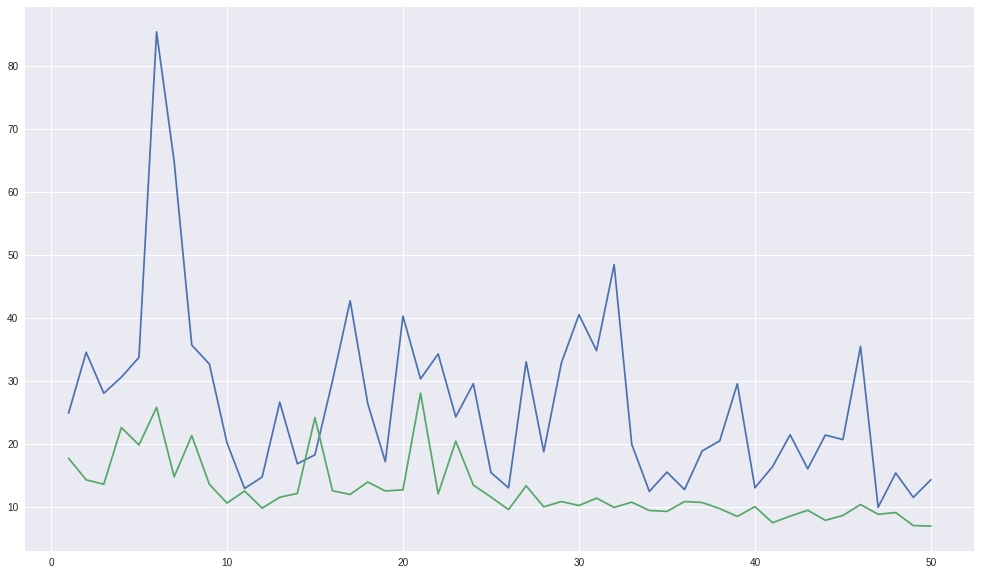

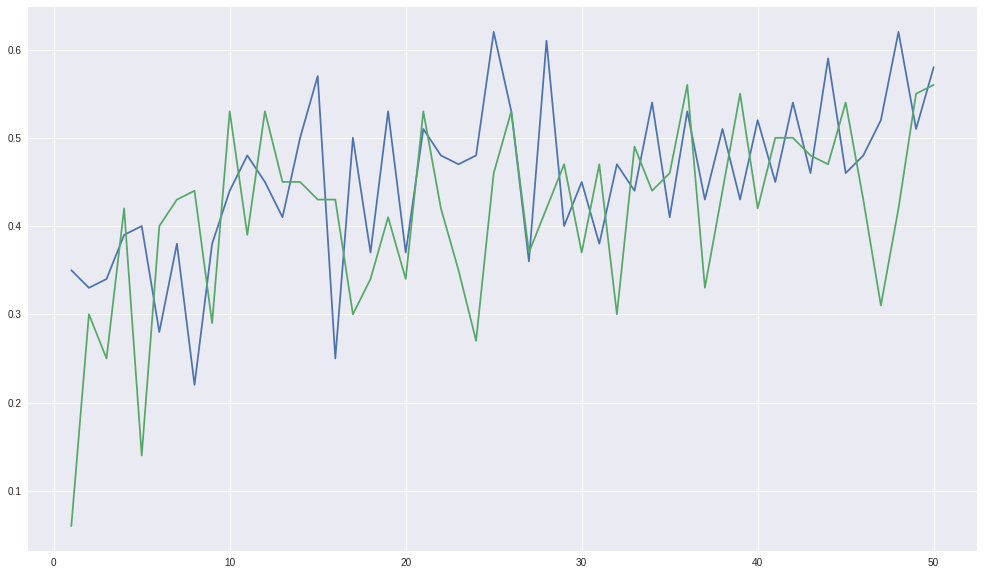

In [19]:
plt.figure(figsize=(17,10))
plt.plot(results['Epoch'], results['Train Loss'])
plt.plot(results['Epoch'], results['Val Loss'])

plt.figure(figsize=(17,10))
plt.plot(results['Epoch'], results['Train acc'])
plt.plot(results['Epoch'], results['Val acc'])